# Taurus

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Taurus/'
name = 'taurus_L1495'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = path + 'HGBS_' + name + '_column_density_map.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

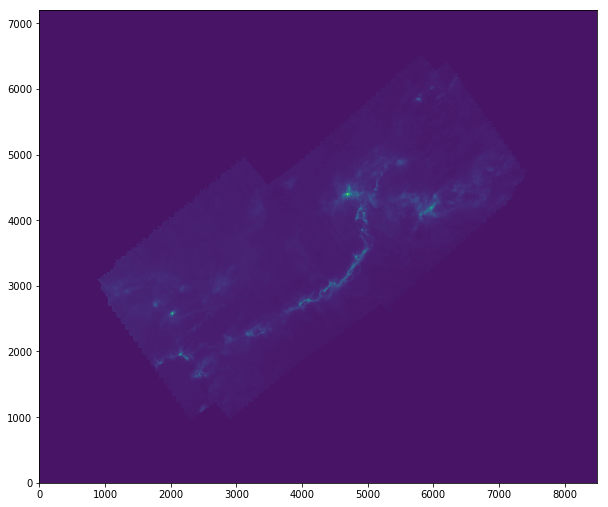

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [5]:
header

SIMPLE  =                    T / Written by IDL:  Thu May  9 19:09:57 2019      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 8500 /Number of positions along axis 1                
NAXIS2  =                 7200 /Number of positions along axis 2                
CTYPE1  = 'RA---TAN'           / Coordinate Type                                
CTYPE2  = 'DEC--TAN'           / Coordinate Type                                
EQUINOX =                 2000 /Equinox of Ref. Coord.                          
CDELT1  =         -0.000833333 / Degrees / Pixel                                
CDELT2  =          0.000833333 / Degrees / Pixel                                
CROTA2  =              0.00000 / Rotation Angle (Degrees)                       
CRPIX1  =            4250.5000 / Reference Pixel in X                           
CRPIX2  =            3600.50

In [6]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to -6.875e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.441e+22 [aplpy.core]


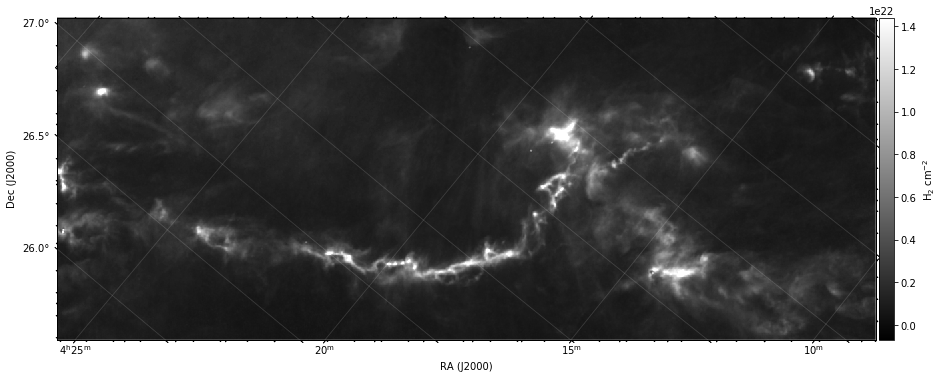

In [7]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
#fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [8]:
#Cut the map
input = path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits'
output = path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits'
coords = np.array([5,5,1234,488])
subfits(input,output,coords)

Dimensions 1230 484


In [9]:
#Read cut map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header
print(im.shape)

(484, 1230)


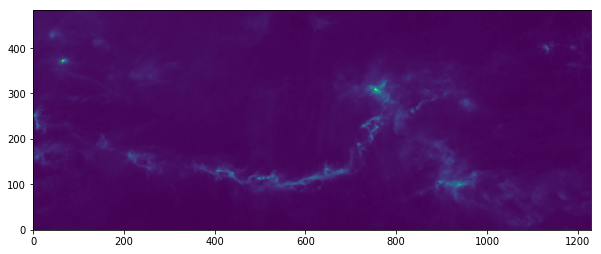

In [10]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [11]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im #- meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((600,1350))
#newdim = np.array((1300,1300))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#noise = S1a[0,20]

In [12]:
#Set a list of q
q=[]
q=[2.6]*28

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

1350 600


Text(0.5, 1.0, 'Beam power spectrum')

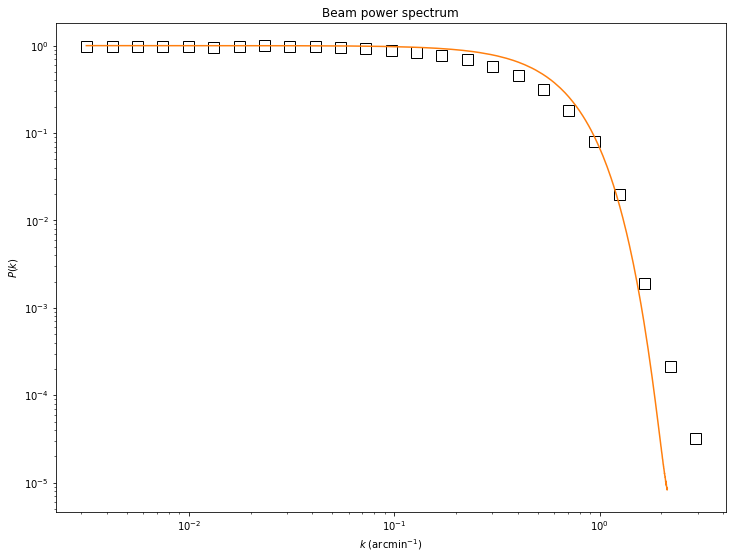

In [14]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[4]
BS1an[:4] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[1],newdim[0],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

In [54]:
np.std(S1a[1,6:24]/BS1an[6:24]/1e41)

3509.4491850013414

Power law fit
Total wavelet
A, Gamma, P0 =  3.3976e+41 -2.41956 9.51495e+39
Coherent wavelet
A, Gamma, P0 =  2.97935e+41 -2.50639 5.14726e+39
Gaussian wavelet
A, Gamma, P0 =  7.53819e+37 -4.53109 4.13822e+40


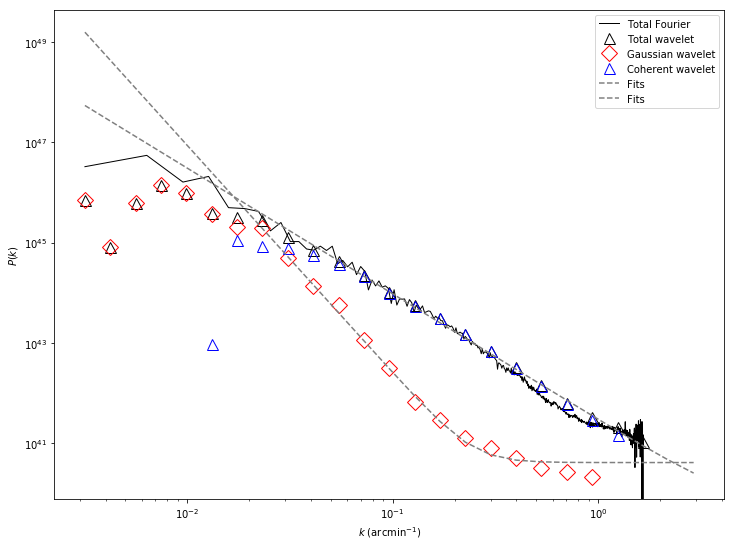

In [71]:
Noise = spec_k[-1]

#Power spectra fits
A_gauss, gamma_gauss, P0_gauss = 0.000753819e+41, -4.53109, 0.413822e+41
fit_gauss=A_gauss*wav_k**gamma_gauss+P0_gauss
A_cohe, gamma_cohe, P0_cohe = 2.97935e+41, -2.50639, 0.0514726e+41
fit_cohe=A_cohe*wav_k**gamma_cohe+P0_cohe
A_spec, gamma_spec, P0_spec = 3.39760e+41, -2.41956, 0.0951495e+41
fit_spec=A_spec*wav_k**gamma_spec+P0_spec

print('Power law fit')
print('Total wavelet')
print('A, Gamma, P0 = ', A_spec, gamma_spec, P0_spec)
print('Coherent wavelet')
print('A, Gamma, P0 = ', A_cohe, gamma_cohe, P0_cohe)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', A_gauss, gamma_gauss, P0_gauss)

plt.figure(figsize(12,9))
plt.plot(tab_k[:-150], (spec_k[:-150]-Noise)/spec_beamn[:-150], lw=1, color='black',label=r'Total Fourier')
#plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5, label=r'Fits')
#plt.plot(wav_k, fit_spec, color='grey', ls='--', lw=1.5, label=r'Fits')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

Text(0.5, 1.0, 'Scale-free fractal simulation')

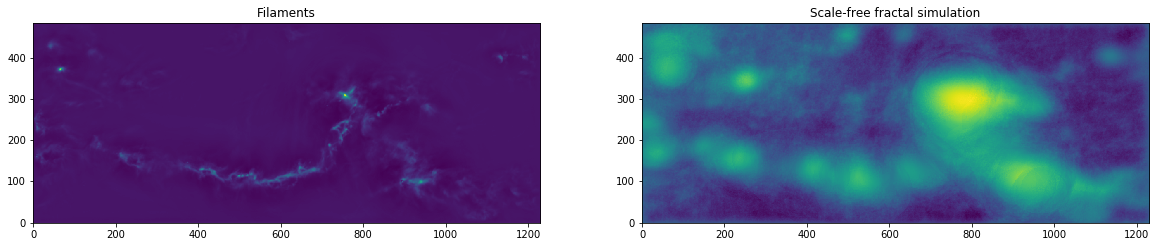

In [72]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)

fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits', filaments, overwrite=True)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits', scale_free, overwrite=True)

#Plot images
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(filaments,origin='bottom')
plt.title('Filaments')

plt.subplot(1,2,2)
imshow(scale_free,origin='bottom')
plt.title('Scale-free fractal simulation')